# Grounding-Sam
- 참고 문서
    - https://github.com/autodistill/autodistill/blob/main/docs/base_models/groundedsam.md

In [ ]:
# 사전 설치
# !pip install autodistill-grounded-sam

### 폴더 생성 그 후 1차 검증한 영상 videos 폴더에 넣기

In [ ]:
# 폴더 생성
import os

if os.path.exists('./videos') == False and os.path.exists('./images') == False:
    os.mkdir('./videos')
    os.mkkir('./images')
    print
else:
    pass

In [8]:
# 경로 지정
VIDEO_DIR_PATH = './videos'
IMAGE_DIR_PATH = './images'

# 프레임 지정
FRAME_STRIDE = 10

### 동영상 파일 읽어서 이미지 분리

In [9]:
import supervision as sv
from tqdm.notebook import tqdm

video_paths = sv.list_files_with_extensions(
    directory=VIDEO_DIR_PATH,
    # 동영상 파일 확장자 지정하는 곳
    extensions=["mov", "mp4"])

# train, test 비디오 지정
TEST_VIDEO_PATHS, TRAIN_VIDEO_PATHS = video_paths[:2], video_paths[2:]

for video_path in tqdm(TRAIN_VIDEO_PATHS):
    video_name = video_path.stem
    image_name_pattern = video_name + "-{:05d}.png"
    with sv.ImageSink(target_dir_path=IMAGE_DIR_PATH, image_name_pattern=image_name_pattern) as sink:
        for image in sv.get_video_frames_generator(source_path=str(video_path), stride=FRAME_STRIDE):
            sink.save_image(image=image)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# 이미지 전체 개수 파악
import supervision as sv

image_paths = sv.list_files_with_extensions(
    directory=IMAGE_DIR_PATH,
    extensions=["png", "jpg", "jpg"])

print('image count:', len(image_paths))

### 이미지 분리된거 시각화

In [11]:
IMAGE_DIR_PATH = "./images"
SAMPLE_SIZE = 16
SAMPLE_GRID_SIZE = (4, 4)
SAMPLE_PLOT_SIZE = (16, 16)

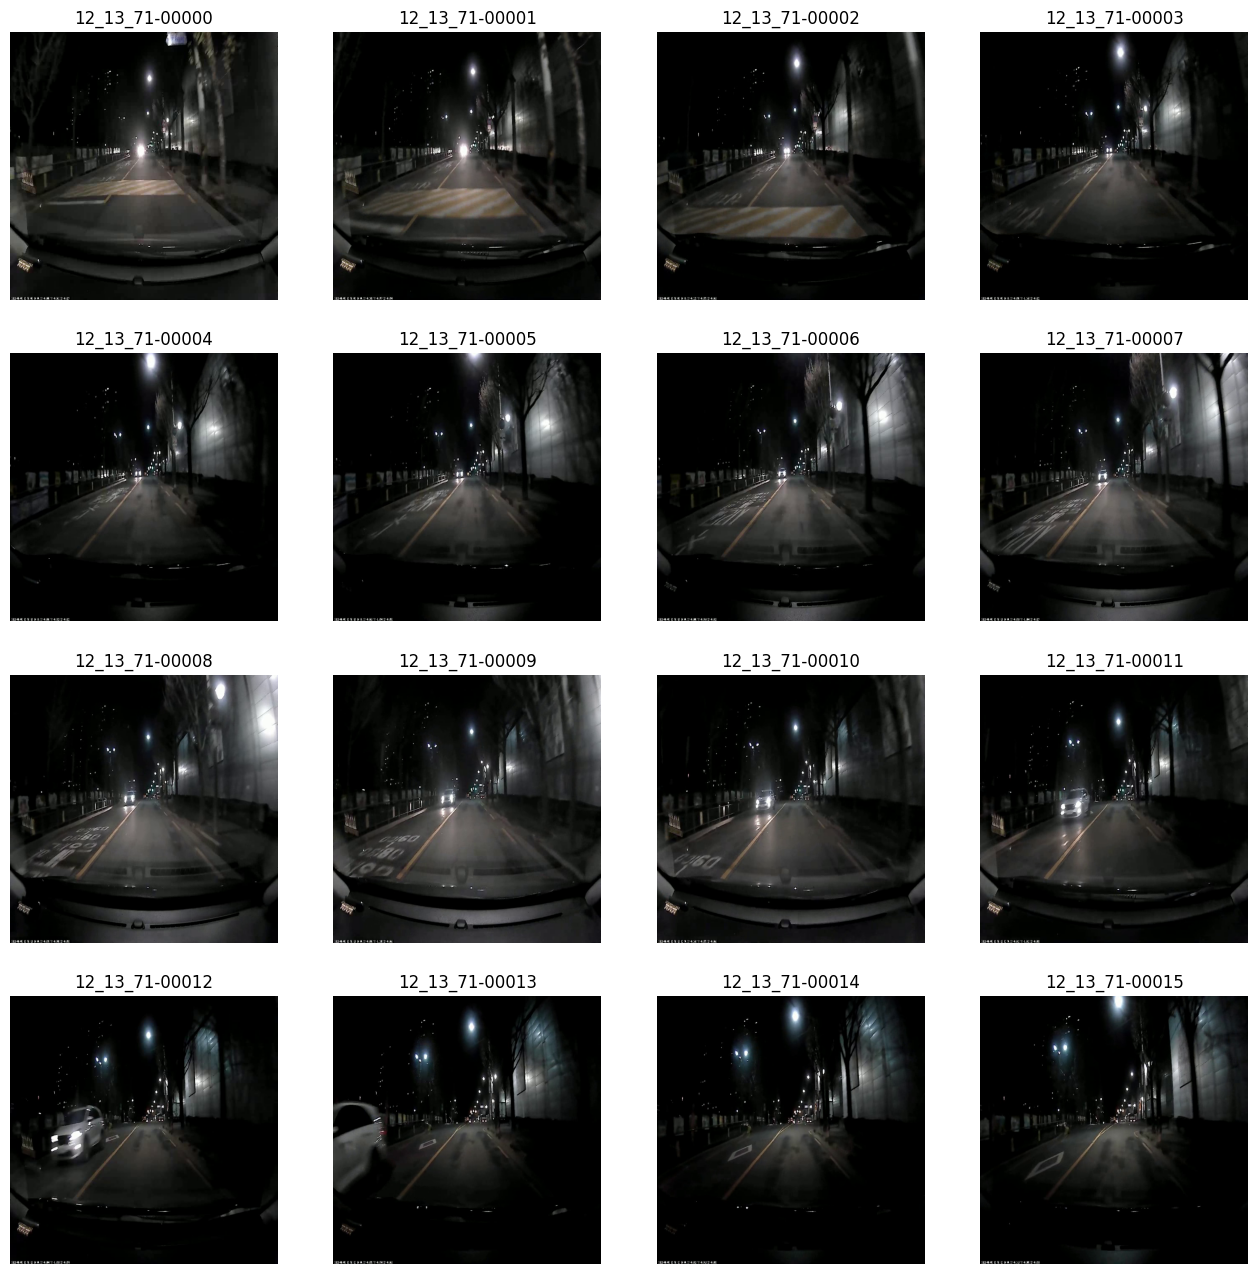

In [12]:
import cv2
import supervision as sv

titles = [
    image_path.stem
    for image_path
    in image_paths[:SAMPLE_SIZE]]
images = [
    cv2.imread(str(image_path))
    for image_path
    in image_paths[:SAMPLE_SIZE]]

sv.plot_images_grid(images=images, titles=titles, grid_size=SAMPLE_GRID_SIZE, size=SAMPLE_PLOT_SIZE)

In [13]:
import torch

# GPU 사용 여부 확인
if torch.cuda.is_available():
    print("GPU 사용 가능")
else:
    print("GPU 사용 불가능")

GPU 사용 가능


In [14]:
import tensorflow as tf

# GPU 사용 여부 확인
if tf.config.list_physical_devices("GPU"):
    print("GPU 사용 가능")
else:
    print("GPU 사용 불가능")


GPU 사용 불가능


### 오토 라벨링 전 클래스 지정

In [18]:
# 오토 라벨링 작업전 클래스 지정
from autodistill_grounding_dino import GroundingDINO
from autodistill.detection import CaptionOntology

ontology=CaptionOntology({
    "person": "person",
    "bicycle": "bicycle",
    'car' : 'car',
    'motorcycle' : 'motorcycle',
    'bus' : 'bus',
    'truck' : 'truck'
})


In [19]:
DATASET_DIR_PATH = /dataset"

In [20]:
from autodistill_grounded_sam import GroundedSAM

base_model = GroundedSAM(ontology=ontology)
dataset = base_model.label(
    input_folder='./images/',
    extension=".png",
    output_folder='./sam_dataset')

trying to load grounding dino directly
final text_encoder_type: bert-base-uncased


Labeling d:\autolabeling/images\12_13_71-00180.png: 100%|██████████| 181/181 [11:19:27<00:00, 225.23s/it] 


Labeled dataset created - ready for distillation.


### supvervision 사용하여 객체 탐지

In [21]:
ANNOTATIONS_DIRECTORY_PATH = './sam_dataset/annotations/'
IMAGES_DIRECTORY_PATH = "./sam_dataset/images/"
DATA_YAML_PATH = "./sam_dataset/data.yaml"

In [22]:
import supervision as sv

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

len(dataset)

144

### 라벨링 후 txt파일로 시각화

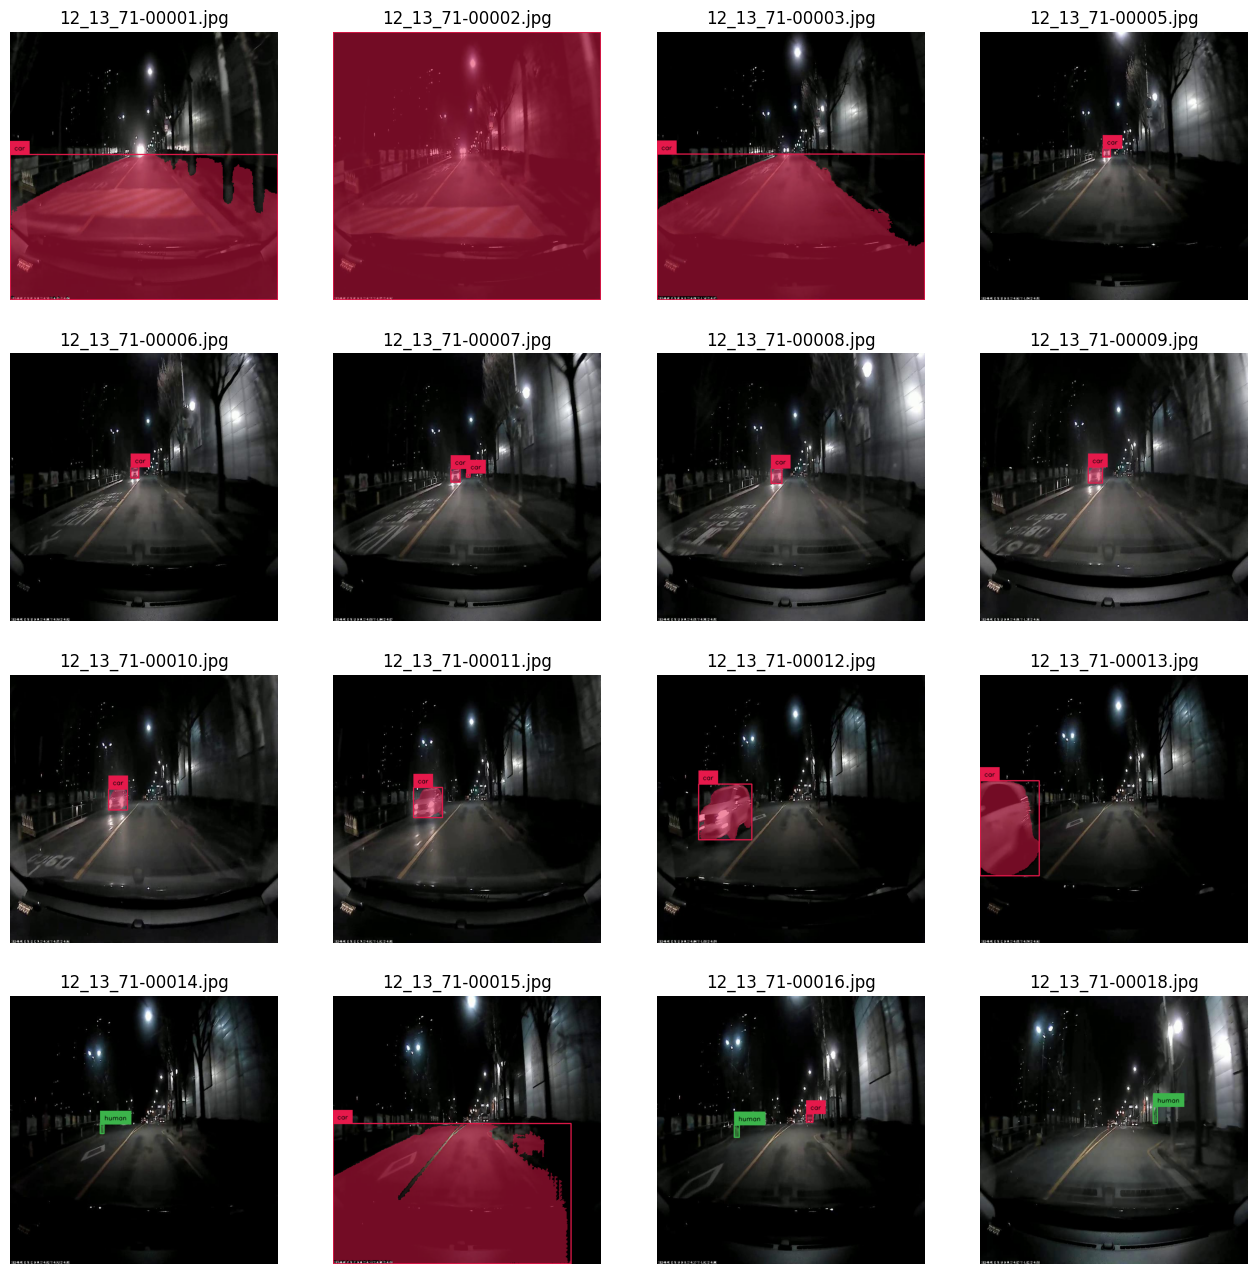

In [23]:
import supervision as sv

image_names = list(dataset.images.keys())[:SAMPLE_SIZE]

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

images = []
for image_name in image_names:
    image = dataset.images[image_name]
    annotations = dataset.annotations[image_name]
    labels = [
        dataset.classes[class_id]
        for class_id
        in annotations.class_id]
    annotates_image = mask_annotator.annotate(
        scene=image.copy(),
        detections=annotations)
    annotates_image = box_annotator.annotate(
        scene=annotates_image,
        detections=annotations,
        labels=labels)
    images.append(annotates_image)

sv.plot_images_grid(
    images=images,
    titles=image_names,
    grid_size=SAMPLE_GRID_SIZE,
    size=SAMPLE_PLOT_SIZE)